<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/Taiwo_Omoya_Linear_Probing_Qwen_3_0_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When a model makes a correct prediction on a task it has been trained on, Probing classifeier can be used to identify if the model actually contains the relevant informatioin or knowledge required to make that prediction, or it is just making a lucky guess
- can be used to identify crucial insights for developing better models over time


### How it works

A nn takes it's input as a series of vectors, or representations, and transform them through a series of layers to produce an output
- develop representations that useful so that the final few layers of the network can be a good prediction

### Probes
- a features or representations from the model are easily seperable by a simple classifier ==> a probe
The only way the probe can perform well on this task is if the representation it is given are already good enough to make the prediction



In [2]:
# Install and load the model
!pip install transformers accelerate



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Load the Processed Dataset: Using the shared dataset generated with Fourth Method (balanced 1:1 labels per query)

In [4]:
!ls -lh "/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused"


ls: cannot access '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/train': No such file or directory


In [6]:
from datasets import load_from_disk

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os

# Check your shared folders manually
!ls "/content/drive/My Drive/Algoverse-AI-Model-Probing"
!ls "/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/train"



# Load the focused dataset
train_path="/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/train"
test_path="/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/test"

probe_train_dataset = load_from_disk(train_path)
probe_test_dataset = load_from_disk(test_path)
print(probe_train_dataset[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cached_activations_3	    new_probe_states_backup_2
hook_results		    probe_dataset_compact
new_analysis_data_backup    probe_dataset_compact_focused
new_analysis_data_backup_2  probe_dataset_longest_context
new_probe_states_backup     probe_states_backup
data-00000-of-00001.arrow  dataset_info.json  state.json
{'text': "Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? To solve this problem, we need to find the total number of flowers in Mark's garden. Let's break down the information given:\n\n1. There are 10 yellow flowers.\n2. There are 80% more purple flowers than yellow. This means that the number of purple flowers is 10 * (1 + 80

In [4]:
import pandas as pd

df = pd.read_csv("processed_dataset(1).csv")
print(df.head())
print(df.columns.tolist())

                                               query  \
0  10 boxes each contain 50 bottles of water. Eac...   
1  10 boxes each contain 50 bottles of water. Eac...   
2  10 boxes each contain 50 bottles of water. Eac...   
3  A convenience store sells 180 gallons of soda ...   
4  A convenience store sells 180 gallons of soda ...   

                                       pivot_context  is_longest_pivot  \
0  10 boxes each contain 50 bottles of water. Eac...             False   
1  10 boxes each contain 50 bottles of water. Eac...             False   
2  10 boxes each contain 50 bottles of water. Eac...              True   
3  A convenience store sells 180 gallons of soda ...             False   
4  A convenience store sells 180 gallons of soda ...             False   

   pivot_start_index  
0                 -1  
1                 -1  
2                 -1  
3                 -1  
4                 -1  
['query', 'pivot_context', 'is_longest_pivot', 'pivot_start_index']


In [15]:
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm

# === Load and Clean Raw Data ===
file_path = "pivotal_tokens.jsonl"
print(f"📂 Loading file: {file_path}")
df = pd.read_json(file_path, lines=True)
print(f"✅ Raw data loaded.\nTotal rows: {len(df)}\n")

print("🔍 Sample rows:")
print(df[["query", "pivot_context"]].head())

# === Load Tokenizer ===
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# === Helper for cleaning text ===
def clean(text):
    return " ".join(text.strip().split())

# === Process rows ===
processed_rows = []
pivot_found = 0
not_found_count = 0

for query_text, group in tqdm(df.groupby("query"), desc="🧹 Processing"):
    group = group.drop_duplicates(subset=["pivot_context"]).copy()
    group["pivot_len"] = group["pivot_context"].apply(lambda x: len(x.split()))
    longest = group.loc[group["pivot_len"].idxmax()]

    for _, row in group.iterrows():
        pivot = row["pivot_context"]
        is_longest = pivot == longest["pivot_context"]

        # Clean text
        query_text_clean = clean(query_text)
        pivot_clean = clean(pivot)

        # Tokenize
        query_tokens = tokenizer(query_text_clean, add_special_tokens=False)["input_ids"]
        pivot_tokens = tokenizer(pivot_clean, add_special_tokens=False)["input_ids"]

        # Try to find pivot_tokens in query_tokens
        match_idx = -1
        for i in range(len(query_tokens) - len(pivot_tokens) + 1):
            if query_tokens[i:i + len(pivot_tokens)] == pivot_tokens:
                match_idx = i
                break

        if match_idx == -1:
            not_found_count += 1
            print("\n[!] Pivot context not found:")
            print(f"Query: {query_text}")
            print(f"Pivot: {pivot}")
            print(f"Query Tokens: {tokenizer.convert_ids_to_tokens(query_tokens)}")
            print(f"Pivot Tokens: {tokenizer.convert_ids_to_tokens(pivot_tokens)}")
            continue

        pivot_found += 1
        processed_rows.append({
            "query": query_text,
            "pivot_context": pivot,
            "pivot_start_token_idx": match_idx,
            "is_longest_pivot": is_longest
        })

# === Save processed data ===
processed_df = pd.DataFrame(processed_rows)
output_path = "processed_dataset.csv"
processed_df.to_csv(output_path, index=False)

# === Summary ===
print(f"\n✅ Processed {len(df)} rows")
print(f"🔍 Pivot found in {pivot_found} rows ({round(pivot_found / len(df) * 100, 1)}%)")
print(f"⚠️  Pivot NOT found in {not_found_count} rows")
print(f"💾 Saved to '{output_path}'")


📂 Loading file: pivotal_tokens.jsonl
✅ Raw data loaded.
Total rows: 971

🔍 Sample rows:
                                               query  \
0  A tomato plant has 100 tomatoes. Jane picks 1/...   
1  A tomato plant has 100 tomatoes. Jane picks 1/...   
2  A tomato plant has 100 tomatoes. Jane picks 1/...   
3  A tomato plant has 100 tomatoes. Jane picks 1/...   
4  A tomato plant has 100 tomatoes. Jane picks 1/...   

                                       pivot_context  
0  A tomato plant has 100 tomatoes. Jane picks 1/...  
1  A tomato plant has 100 tomatoes. Jane picks 1/...  
2  A tomato plant has 100 tomatoes. Jane picks 1/...  
3  A tomato plant has 100 tomatoes. Jane picks 1/...  
4  A tomato plant has 100 tomatoes. Jane picks 1/...  


🧹 Processing:   5%|▍         | 2/44 [00:00<00:03, 13.59it/s]


[!] Pivot context not found:
Query: 10 boxes each contain 50 bottles of water. Each bottle has a capacity of 12 liters and is filled up to 3/4 of its capacity. How many liters of water altogether are contained within the bottles in the boxes?
Pivot: 10 boxes each contain 50 bottles of water. Each bottle has a capacity of 12 liters and is filled up to 3/4 of its capacity. How many liters of water altogether are contained within the bottles in the boxes? To find the total amount of water in the bottles, we need to calculate the total capacity of all the bottles first. Since there are 10 boxes and each box has 50 bottles, the total number of bottles is 10 * 50 = 500 bottles. Each bottle has a capacity of 12 liters, so the total capacity is 500 * 12 = 6000 liters.
Query Tokens: ['1', '0', 'Ġboxes', 'Ġeach', 'Ġcontain', 'Ġ', '5', '0', 'Ġbottles', 'Ġof', 'Ġwater', '.', 'ĠEach', 'Ġbottle', 'Ġhas', 'Ġa', 'Ġcapacity', 'Ġof', 'Ġ', '1', '2', 'Ġliters', 'Ġand', 'Ġis', 'Ġfilled', 'Ġup', 'Ġto', 'Ġ'

🧹 Processing:  14%|█▎        | 6/44 [00:00<00:03, 11.88it/s]


[!] Pivot context not found:
Query: A portable battery charger can fully charge a smartphone in 26 minutes or a tablet in 53 minutes. Ana charged her tablet fully and her phone halfway. How many minutes did it take?
Pivot: A portable battery charger can fully charge a smartphone in 26 minutes or a tablet in 53 minutes. Ana charged her tablet fully and her phone halfway. How many minutes did it take? To find the total time, you need to calculate the time required to charge the phone and the tablet separately, and then add them together. 

First, let's find the time required to charge the phone. The phone needs 26 minutes to fully charge. 

Next, let's find the time required to charge the tablet. The tablet needs 53 minutes to fully charge, but Ana charged her tablet
Query Tokens: ['A', 'Ġportable', 'Ġbattery', 'Ġcharger', 'Ġcan', 'Ġfully', 'Ġcharge', 'Ġa', 'Ġsmartphone', 'Ġin', 'Ġ', '2', '6', 'Ġminutes', 'Ġor', 'Ġa', 'Ġtablet', 'Ġin', 'Ġ', '5', '3', 'Ġminutes', '.', 'ĠAna', 'Ġcharged',

🧹 Processing:  18%|█▊        | 8/44 [00:00<00:03, 11.14it/s]


[!] Pivot context not found:
Query: After Bella’s ballet performance, she received 2 dozen roses from her parents, and 2 roses from each of her 10 dancer friends. How many roses did Bella receive?
Pivot: After Bella’s ballet performance, she received 2 dozen roses from her parents, and 2 roses from each of her 10 dancer friends. How many roses did Bella receive? Let's solve this problem.
To solve the problem, we need to calculate the total number of roses Bella received. The problem states that she received 2 dozen roses from her parents and 2 roses from each of her 10 dancer friends. 

First, we need to convert the number of dozen into a more familiar unit of measurement. A dozen is 12 roses, so 2 dozen is equal to 2 times 12, which is 24 roses.

Next, we calculate the number of roses from her 10 dancer friends. Since each friend gives her 2 roses, we multiply the number of friends by the number of roses per friend: 10 friends × 2 roses = 20 roses.

Finally, we add the number of rose

🧹 Processing:  23%|██▎       | 10/44 [00:00<00:02, 13.14it/s]


[!] Pivot context not found:
Query: Amy biked 12 miles yesterday. If she biked 3 miles less than twice as far as yesterday, how many miles did she bike in total in the two days?
Pivot: Amy biked 12 miles yesterday. If she biked 3 miles less than twice as far as yesterday, how many miles did she bike in total in the two days? To solve this problem, we need to find the total number of miles Amy biked in two days. 

First, we need to find out how many miles Amy biked yesterday, which is 12 miles. Then, we need to find out how many miles she biked today, which is 3 miles less than twice as far as yesterday. To calculate this, we can use the formula: "twice as far as yesterday" is 2 * 12 = 24 miles. Then, subtract 3 miles to find the number of miles she biked today, which is 24 - 3 = 21 miles. Finally, we add the miles she biked yesterday and today to get the total number of miles she biked in the two days: 12 + 21 = 33 miles.

To ensure the calculation is correct, let's break it down step

🧹 Processing:  27%|██▋       | 12/44 [00:01<00:03, 10.39it/s]


[!] Pivot context not found:
Query: Bella is making bracelets for her 6 friends. She needs 8 beads per bracelet. She has 36 beads. How many more beads does she need to make all six bracelets?
Pivot: Bella is making bracelets for her 6 friends. She needs 8 beads per bracelet. She has 36 beads. How many more beads does she need to make all six bracelets? Also, can you explain how to solve this problem?

Let's
Query Tokens: ['B', 'ella', 'Ġis', 'Ġmaking', 'Ġbracelets', 'Ġfor', 'Ġher', 'Ġ', '6', 'Ġfriends', '.', 'ĠShe', 'Ġneeds', 'Ġ', '8', 'Ġbeads', 'Ġper', 'Ġbracelet', '.', 'ĠShe', 'Ġhas', 'Ġ', '3', '6', 'Ġbeads', '.', 'ĠHow', 'Ġmany', 'Ġmore', 'Ġbeads', 'Ġdoes', 'Ġshe', 'Ġneed', 'Ġto', 'Ġmake', 'Ġall', 'Ġsix', 'Ġbracelets', '?']
Pivot Tokens: ['B', 'ella', 'Ġis', 'Ġmaking', 'Ġbracelets', 'Ġfor', 'Ġher', 'Ġ', '6', 'Ġfriends', '.', 'ĠShe', 'Ġneeds', 'Ġ', '8', 'Ġbeads', 'Ġper', 'Ġbracelet', '.', 'ĠShe', 'Ġhas', 'Ġ', '3', '6', 'Ġbeads', '.', 'ĠHow', 'Ġmany', 'Ġmore', 'Ġbeads', 'Ġdoes', 'Ġsh

🧹 Processing:  36%|███▋      | 16/44 [00:01<00:02, 12.04it/s]


[!] Pivot context not found:
Query: Ben has 8 apples more than Phillip does. Tom has three eighths as many apples at Ben has. If Phillip has 40 apples, how many apples does Tom have?
Pivot: Ben has 8 apples more than Phillip does. Tom has three eighths as many apples at Ben has. If Phillip has 40 apples, how many apples does Tom have? To solve this problem, we need to determine how many apples Tom has based on the given information. Let's break down the problem step by step.

First, we know that Ben has 8 apples more than Phillip. Since Phillip has 40 apples, we can find out how many apples Ben has by adding 8 to 40. 

Next, we are told that Tom has three eighths as many apples as Ben does. So, we need to calculate 3/8 of the number of apples Ben has. 

Let's compute the number of apples Ben has first:
Ben's apples = Phillip's apples +
Query Tokens: ['Ben', 'Ġhas', 'Ġ', '8', 'Ġapples', 'Ġmore', 'Ġthan', 'ĠPhillip', 'Ġdoes', '.', 'ĠTom', 'Ġhas', 'Ġthree', 'Ġe', 'igh', 'ths', 'Ġas', 'Ġm

🧹 Processing:  45%|████▌     | 20/44 [00:01<00:02, 11.32it/s]


[!] Pivot context not found:
Query: During a commercial break in the Super Bowl, there were three 5-minute commercials and eleven 2-minute commercials. How many minutes was the commercial break?
Pivot: During a commercial break in the Super Bowl, there were three 5-minute commercials and eleven 2-minute commercials. How many minutes was the commercial break? To the nearest minute, how many minutes was the commercial break?

First, let's determine the total number of commercials and then calculate the total time.

Let's find the total number of commercials first.

We have three 5-minute commercials and eleven 2-minute commercials. So the total number of commercials is 3 + 11 = 14.

Now, the total time is the sum of the time for each commercial.
Query Tokens: ['During', 'Ġa', 'Ġcommercial', 'Ġbreak', 'Ġin', 'Ġthe', 'ĠSuper', 'ĠBowl', ',', 'Ġthere', 'Ġwere', 'Ġthree', 'Ġ', '5', '-minute', 'Ġcommercials', 'Ġand', 'Ġeleven', 'Ġ', '2', '-minute', 'Ġcommercials', '.', 'ĠHow', 'Ġmany', 'Ġminu

🧹 Processing:  50%|█████     | 22/44 [00:02<00:03,  6.68it/s]


[!] Pivot context not found:
Query: In Fifi's closet, she hangs all of her clothes on colored plastic hangers. She has clothes hanging on 7 pink hangers, 4 green hangers, one less blue hanger than there are green hangers, and one less yellow hanger than there are blue hangers. What is the total number of colored hangers in Fifi's closet?
Pivot: In Fifi's closet, she hangs all of her clothes on colored plastic hangers. She has clothes hanging on 7 pink hangers, 4 green hangers, one less blue hanger than there are green hangers, and one less yellow hanger than there are blue hangers. What is the total number of colored hangers in Fifi's closet? To solve this, let's break down the problem step by step.

First, we need to determine the number of colored hangers. According to the problem, the number of colored hangers is equal to the sum of the number of pink, green, blue, and yellow hangers.

Let's denote the number of pink hangers as P, green hangers as G, blue hangers as B, and yellow h

🧹 Processing:  57%|█████▋    | 25/44 [00:02<00:02,  9.04it/s]


[!] Pivot context not found:
Query: Jennifer's boyfriend left 5 texts about the grocery shopping, 5 times more texts asking why she wasn't responding, and a number of texts equal to 10% of all the texts he sent previously saying he was calling the police. How many texts did he send total?
Pivot: Jennifer's boyfriend left 5 texts about the grocery shopping, 5 times more texts asking why she wasn't responding, and a number of texts equal to 10% of all the texts he sent previously saying he was calling the police. How many texts did he send total? 

To find the total number of texts, we need to sum up the number of texts from each category. Let's break it down:

1. First category: 5 texts
2. Second category: 5 times more than the first category, which is 5*5 = 25 texts
3. Third category: 10% of the previous texts, which is 0.10*5 = 0.5 texts
4. Then, add all three categories together: 5 + 25 + 0.5 = 30.5 texts

Wait, but the problem says "10% of all the texts he sent previously". So if t

🧹 Processing:  66%|██████▌   | 29/44 [00:03<00:01,  8.41it/s]


[!] Pivot context not found:
Query: John uses 5 liters of fuel per km to travel. How many liters of fuel should John plan to use if he plans to travel on two trips of 30 km and 20 km?
Pivot: John uses 5 liters of fuel per km to travel. How many liters of fuel should John plan to use if he plans to travel on two trips of 30 km and 20 km? Also, what is the total fuel needed for the two trips?

Let me try to solve this problem.

First, I need to calculate the total fuel required for the two trips. The fuel needed per trip is 5 liters per km. So, for the first trip, which is 30 km, it's 5 * 30 = 150 liters. For the second trip, 20 km, it's 5 * 20 = 100 liters. Adding these together, 150 + 100 = 250 liters. So the total fuel needed is 250 liters.

But wait, let me double-check. If he plans to travel on two trips of 30 and 20 km, then the total distance is 30 + 20 = 50 km. The fuel needed per km is 5 liters, so total fuel is 5 * 50 = 250 liters. Yes, that matches. So the answer should be 25

🧹 Processing:  70%|███████   | 31/44 [00:03<00:01,  9.27it/s]


[!] Pivot context not found:
Query: Marie has 98 unread messages on her phone. She decides to clear them by reading 20 messages a day. However, she also gets 6 new messages a day. How many days will it take her to read all her unread messages?
Pivot: Marie has 98 unread messages on her phone. She decides to clear them by reading 20 messages a day. However, she also gets 6 new messages a day. How many days will it take her to read all her unread messages? Let's solve this problem.
To solve this problem, we need to determine how many days it will take Marie to read all her unread messages, considering both the messages she reads and the messages she gets. 

We are given:
- Initial unread messages: 98
- Messages she reads per day: 20
-
Query Tokens: ['Mar', 'ie', 'Ġhas', 'Ġ', '9', '8', 'Ġunread', 'Ġmessages', 'Ġon', 'Ġher', 'Ġphone', '.', 'ĠShe', 'Ġdecides', 'Ġto', 'Ġclear', 'Ġthem', 'Ġby', 'Ġreading', 'Ġ', '2', '0', 'Ġmessages', 'Ġa', 'Ġday', '.', 'ĠHowever', ',', 'Ġshe', 'Ġalso', 'Ġget

🧹 Processing:  75%|███████▌  | 33/44 [00:03<00:01,  9.58it/s]


[!] Pivot context not found:
Query: Mr. Sanchez found out that 40% of his Grade 5 students got a final grade below B. How many of his students got a final grade of B and above if he has 60 students in Grade 5?
Pivot: Mr. Sanchez found out that 40% of his Grade 5 students got a final grade below B. How many of his students got a final grade of B and above if he has 60 students in Grade 5? To find the number of students who got a final grade of B and above, we can use the formula: Number of students with B and above = Total students - Number of students with grades below B. Plugging in the numbers, we get 60 -
Query Tokens: ['Mr', '.', 'ĠSanchez', 'Ġfound', 'Ġout', 'Ġthat', 'Ġ', '4', '0', '%', 'Ġof', 'Ġhis', 'ĠGrade', 'Ġ', '5', 'Ġstudents', 'Ġgot', 'Ġa', 'Ġfinal', 'Ġgrade', 'Ġbelow', 'ĠB', '.', 'ĠHow', 'Ġmany', 'Ġof', 'Ġhis', 'Ġstudents', 'Ġgot', 'Ġa', 'Ġfinal', 'Ġgrade', 'Ġof', 'ĠB', 'Ġand', 'Ġabove', 'Ġif', 'Ġhe', 'Ġhas', 'Ġ', '6', '0', 'Ġstudents', 'Ġin', 'ĠGrade', 'Ġ', '5', '?']
Piv

🧹 Processing:  80%|███████▉  | 35/44 [00:03<00:00,  9.43it/s]


[!] Pivot context not found:
Query: Nine members of the crafts club are making 2 necklaces each. It takes 50 beads to make each necklace. How many beads will they need in all?
Pivot: Nine members of the crafts club are making 2 necklaces each. It takes 50 beads to make each necklace. How many beads will they need in all? Let's try to solve this problem step by step.

First, let's understand the problem. There are 9 members in the crafts club. Each member is making 2 necklaces. So, the total number of necklaces needed is 9 multiplied by 2, which equals 18. 

Now, each necklace requires 50 beads. Therefore, the total number of beads needed for all 18 necklaces would be 18 multiplied by 50. Let's calculate that. 

18 * 50 is equal to... Well, 18 times 50 is straightforward. Breaking it down, 10 times 50 is 500, and 8 times 50 is 400. Adding those together gives 500 + 400 = 900. 

So, the total number of beads required is 900. Let me double-check the calculations to make sure there's no e

🧹 Processing:  89%|████████▊ | 39/44 [00:03<00:00, 10.91it/s]


[!] Pivot context not found:
Query: On Thursday Walmart sold 210 pounds of ground beef. On Friday they sold twice that amount. On Saturday they only sold 150 pounds. What was the average amount of beef sold per day?
Pivot: On Thursday Walmart sold 210 pounds of ground beef. On Friday they sold twice that amount. On Saturday they only sold 150 pounds. What was the average amount of beef sold per day? Let's see, the problem says that on Thursday, they sold 210 pounds. On Friday, twice that amount. So, 210 * 2 = 420 pounds. Then, on Saturday, 150 pounds. So, total is 210 + 420 + 150. Let me add those numbers. 210 + 420 is 630, plus 150 is 780. So, the total is 780 pounds. To find the average per day, divide by the number of days. There are 3 days, so 780 / 3 = 260. Therefore, the average is 260 pounds per day. Let me check if that makes sense. Yes, 210 + 420 + 150 = 780, and 780 divided by 3 is 260. So, the answer should be 260.
**Final Answer**
The average amount of beef sold per day is

🧹 Processing:  93%|█████████▎| 41/44 [00:04<00:00, 11.61it/s]


[!] Pivot context not found:
Query: Russel and Jen went to the circus. Jen played a shooting game twice, while Russel rode the carousel three times. If the shooting game costs 5 tickets and the carousel costs 3 tickets. How many tickets did they use?
Pivot: Russel and Jen went to the circus. Jen played a shooting game twice, while Russel rode the carousel three times. If the shooting game costs 5 tickets and the carousel costs 3 tickets. How many tickets did they use? Let's see. 

First
Query Tokens: ['Russ', 'el', 'Ġand', 'ĠJen', 'Ġwent', 'Ġto', 'Ġthe', 'Ġcircus', '.', 'ĠJen', 'Ġplayed', 'Ġa', 'Ġshooting', 'Ġgame', 'Ġtwice', ',', 'Ġwhile', 'ĠRuss', 'el', 'Ġrode', 'Ġthe', 'Ġcarousel', 'Ġthree', 'Ġtimes', '.', 'ĠIf', 'Ġthe', 'Ġshooting', 'Ġgame', 'Ġcosts', 'Ġ', '5', 'Ġtickets', 'Ġand', 'Ġthe', 'Ġcarousel', 'Ġcosts', 'Ġ', '3', 'Ġtickets', '.', 'ĠHow', 'Ġmany', 'Ġtickets', 'Ġdid', 'Ġthey', 'Ġuse', '?']
Pivot Tokens: ['Russ', 'el', 'Ġand', 'ĠJen', 'Ġwent', 'Ġto', 'Ġthe', 'Ġcircus', '.', '

🧹 Processing: 100%|██████████| 44/44 [00:04<00:00, 10.23it/s]


[!] Pivot context not found:
Query: The Dark Lord needs to transport 1200 pounds of swords to the Enchanted Forest for a battle with the elves. He has 10 squads of 8 orcs each. How many pounds of swords does each orc have to carry?
Pivot: The Dark Lord needs to transport 1200 pounds of swords to the Enchanted Forest for a battle with the elves. He has 10 squads of 8 orcs each. How many pounds of swords does each orc have to carry? To solve this problem, we can break it down into two parts: first, calculating how many pounds of swords each orc has to carry, and then determining how many squads of 8 orcs each are needed.

The total number of pounds of swords is 1200. There are 10 squads of 8 orcs each, so the total number of orcs is 10 * 8 = 80 orcs. 

To find out how many pounds of swords each orc has to carry, we divide the total pounds by the number of orcs. So, the calculation would be 1200 / 80 = 15. 

Therefore, each orc has to carry 15 pounds of swords. 

The answer is 15.
```pyt

In [ ]:
print(model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

## Query Level Split(train_dataset, val_dataset, test_dataset)

In [ ]:
!pip install datasets scikit-learn pandas --quiet

In [ ]:
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

def split_pts_by_query_three_way(dataset_path: str, val_size: float = 0.1, test_size: float = 0.1, subset_size: int = None):
    """
    Load the PTS dataset and split into train/val/test sets by query ID to prevent data leakage.

    :param dataset_path: Path or name of the dataset (HuggingFace or local)
    :param val_size: Fraction of query IDs to use for validation
    :param test_size: Fraction of query IDs to use for test
    :param subset_size: Optional number of total examples to subsample for quick debugging
    :return: train_dataset, val_dataset, test_dataset
    """
    # Load dataset
    dataset = load_dataset(dataset_path, split='train')

    # Subset for quick debugging
    if subset_size:
        dataset = dataset.select(range(min(subset_size, len(dataset))))

    # Drop duplicates and remove unnecessary columns
    df = dataset.to_pandas()
    if 'timestamp' in df.columns:
        df = df.drop(columns=['timestamp'])
    df = df.drop_duplicates()
    dataset = Dataset.from_pandas(df)

    # Get unique query IDs
    unique_query_ids = list(set(dataset['dataset_item_id']))
    total = len(unique_query_ids)

    # Split into test, val, and train
    query_ids_train_val, query_ids_test = train_test_split(
        unique_query_ids,
        test_size=test_size,
        random_state=42
    )
    query_ids_train, query_ids_val = train_test_split(
        query_ids_train_val,
        test_size=val_size / (1 - test_size),
        random_state=42
    )

    # Filter datasets
    train_dataset = dataset.filter(lambda x: x['dataset_item_id'] in query_ids_train)
    val_dataset = dataset.filter(lambda x: x['dataset_item_id'] in query_ids_val)
    test_dataset = dataset.filter(lambda x: x['dataset_item_id'] in query_ids_test)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_pts_by_query_three_way("codelion/Qwen3-0.6B-pts")
len(train_dataset), len(val_dataset), len(test_dataset)


README.md: 0.00B [00:00, ?B/s]

gsm8k_pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

(909, 144, 192)

## PTSProbeDataset
1. Loads PTS samples(```text```, ```pivotal_tokens```)
2. Tokenizes using Qwen tokenizer
3. Captures residual activations at a chosen layer
4. Aligns pivotal tokens to labels
5. Returns(activation, is_pivotal_label) pairs

In [ ]:
class PTSProbeDataset(Dataset):
    def __init__(self, samples, tokenizer, model, layer_index=15):
        self.samples = samples
        self.tokenizer = tokenizer
        self.model = model
        self.layer_index = layer_index
        self.residuals = []
        self.labels = []

        # Debug: Check initial data
        print(f"Initializing dataset with {len(samples)} samples")
        if len(samples) > 0:
            print(f"First sample keys: {list(samples[0].keys())}")
            print(f"Sample has 'pivot_context': {'pivot_context' in samples[0]}")
            print(f"Sample has 'pivot_token': {'pivot_token' in samples[0]}")

        self._prepare_data()

    def _get_activations_for_sample(self, encoded_input):
        # Method 1: Using hooks (fixed version)
        try:
            activations = {}

            def hook_fn(module, input, output):
                # Handle case where output might be a tuple (hidden_states, attention_weights, etc.)
                if isinstance(output, tuple):
                    # For most transformer layers, hidden states are the first element
                    activations["residual"] = output[0].detach()
                else:
                    activations["residual"] = output.detach()

            handle = self.model.model.layers[self.layer_index].register_forward_hook(hook_fn)

            with torch.no_grad():
                self.model(**encoded_input)

            handle.remove()

            return activations["residual"]

        except Exception as e:
            # Method 2: Fallback - use model's output_hidden_states
            print(f"Hook method failed ({e}), trying output_hidden_states...")
            with torch.no_grad():
                outputs = self.model(**encoded_input, output_hidden_states=True)
                # hidden_states is a tuple of (embedding_layer, layer_0, layer_1, ..., layer_n)
                # So layer_index corresponds to outputs.hidden_states[layer_index + 1]
                return outputs.hidden_states[self.layer_index + 1].detach()

    def _prepare_data(self):
        skipped_empty_resid = 0
        skipped_empty_labels = 0
        skipped_misalignment = 0
        skipped_no_context = 0
        skipped_no_pivot = 0
        successful_samples = 0

        for i, example in enumerate(tqdm(self.samples)):
            # Check for PTS format keys
            if "pivot_context" not in example:
                print(f"Sample {i}: Missing 'pivot_context' key")
                skipped_no_context += 1
                continue

            if "pivot_token" not in example:
                print(f"Sample {i}: Missing 'pivot_token' key")
                skipped_no_pivot += 1
                continue

            # Use PTS format fields
            text = example["pivot_context"]
            pivot_token = example["pivot_token"].strip()

            # Debug: Check text and pivot token
            if not text or not text.strip():
                print(f"Sample {i}: Empty pivot_context")
                skipped_no_context += 1
                continue

            # Enhanced pivot token validation
            if not pivot_token or len(pivot_token) <= 1:  # Skip single characters and spaces
                if i < 10:  # Only print for first 10 samples to avoid spam
                    print(f"Sample {i}: Pivot token too short or empty: '{pivot_token}'")
                skipped_no_pivot += 1
                continue

            if i < 3:  # Debug first few samples
                print(f"Sample {i}: Processing text of length {len(text)}")
                print(f"  Pivot token: '{pivot_token}'")
                print(f"  Text preview: {text[:100]}...")

            try:
                encoded = self.tokenizer(
                    text, return_offsets_mapping=True, return_tensors="pt", truncation=True
                )
                offsets = encoded["offset_mapping"][0].tolist()

                # Debug: Check tokenization
                if i < 3:
                    print(f"Sample {i}: Tokenized to {len(offsets)} tokens")

                # Move to device (check what device model is on)
                device = next(self.model.parameters()).device
                encoded = {k: v.to(device) for k, v in encoded.items() if k != "offset_mapping"}

                resid = self._get_activations_for_sample(encoded).squeeze(0)

                # Debug: Check activations
                if i < 3:
                    print(f"Sample {i}: Got residuals shape {resid.shape}")

                # Create binary labels: 1 if token contains the pivot token, 0 otherwise
                token_labels = []
                pivot_token_lower = pivot_token.lower()

                for j, (start, end) in enumerate(offsets):
                    if start == 0 and end == 0:  # Special tokens
                        token_labels.append(0)
                    else:
                        token_text = text[start:end].lower()
                        # Check if this token matches or contains the pivot token
                        is_pivotal = int(pivot_token_lower in token_text or token_text in pivot_token_lower)
                        token_labels.append(is_pivotal)

                        # Debug: Print token matches for first few samples
                        if i < 3 and is_pivotal:
                            print(f"  Found pivot match - Token {j}: '{token_text}' matches '{pivot_token_lower}'")

                token_labels = torch.tensor(token_labels, dtype=torch.float)

                # Debug: Check labels
                if i < 3:
                    print(f"Sample {i}: Created {len(token_labels)} labels, {token_labels.sum().item()} are pivotal")

                # Validation checks
                if resid.shape[0] == 0:
                    print(f"Sample {i}: Skipping - empty residuals")
                    skipped_empty_resid += 1
                    continue
                elif len(token_labels) == 0:
                    print(f"Sample {i}: Skipping - empty labels")
                    skipped_empty_labels += 1
                    continue
                elif len(token_labels) != resid.shape[0]:
                    print(f"Sample {i}: Skipping - misalignment: token={len(token_labels)}, activations={resid.shape[0]}")
                    skipped_misalignment += 1
                    continue

                self.residuals.append(resid.cpu())
                self.labels.append(token_labels)
                successful_samples += 1

                if i < 3:
                    print(f"Sample {i}: Successfully added to dataset")

            except Exception as e:
                print(f"Sample {i}: Error during processing: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        # Final debug summary
        print(f"\n=== Dataset Preparation Summary ===")
        print(f"Total input samples: {len(self.samples)}")
        print(f"Successful samples: {successful_samples}")
        print(f"Skipped - no pivot_context: {skipped_no_context}")
        print(f"Skipped - no pivot_token: {skipped_no_pivot}")
        print(f"Skipped - empty residuals: {skipped_empty_resid}")
        print(f"Skipped - empty labels: {skipped_empty_labels}")
        print(f"Skipped - misalignment: {skipped_misalignment}")
        print(f"Final dataset size: {len(self.residuals)}")

    def __len__(self):
        return len(self.residuals)

    def __getitem__(self, idx):
        return self.residuals[idx], self.labels[idx]

### Create Train/Val Dataloaders






In [ ]:
def flatten_collate(batch):
    """
    Custom collate function that flattens variable-length sequences.

    Input: batch = [(residuals_1, labels_1), (residuals_2, labels_2), ...]
           where residuals_i has shape [seq_len_i, 1024] and labels_i has shape [seq_len_i]

    Output: (flattened_residuals, flattened_labels)
            where shapes are [total_tokens, 1024] and [total_tokens]
    """
    residuals_list = []
    labels_list = []

    for residuals, labels in batch:
        residuals_list.append(residuals)
        labels_list.append(labels)

    # Concatenate all sequences into one big tensor
    flattened_residuals = torch.cat(residuals_list, dim=0)  # [total_tokens, 1024]
    flattened_labels = torch.cat(labels_list, dim=0)        # [total_tokens]

    return flattened_residuals, flattened_labels

# Updated create_dataloaders function
def create_dataloaders(dataset, split_ratio=0.8, batch_size=32, shuffle=True):
    total = len(dataset)
    train_size = int(total * split_ratio)
    val_size = total - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # Use custom collate function
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=flatten_collate
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=flatten_collate
    )

    return train_loader, val_loader

# Alternative: Reduce batch size to minimize memory usage
def create_dataloaders_small_batch(dataset, split_ratio=0.8, batch_size=8, shuffle=True):
    """Version with smaller batch size for large datasets"""
    total = len(dataset)
    train_size = int(total * split_ratio)
    val_size = total - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,  # Smaller batch size
        shuffle=shuffle,
        collate_fn=flatten_collate
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=flatten_collate
    )

    return train_loader, val_loader


## The probe


In [ ]:
## Create the Linear
# Define the probe ==> a linear layer + sigmoid

import torch.nn as nn

class LinearProbe(nn.Module):
  def __init__(self, hidden_dim=1024):
    super().__init__()
    self.linear = nn.Linear(hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear(x)
    x = self.sigmoid(x).squeeze(-1)
    return x

## Train the probe


In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch

def train_probe(probe, dataloader, num_epochs=5, lr=1e-3, verbose=True, device="cuda"):
    """
    Trains a probe on residual activations with binary labels.

    Args:
        probe (nn.Module): The probe model (e.g., LinearProbe)
        dataloader (DataLoader): Yields batches of (residuals, labels)
        num_epochs (int): Number of training epochs
        lr (float): Learning rate
        verbose (bool): Whether to print training logs
    """
    probe = probe.to(device)
    probe.train()

    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct, total = 0, 0

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = probe(x)  # shape: [batch_size, 1]
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Binary classification accuracy
            predicted = (preds >= 0.5).long()
            correct += (predicted == y.long()).sum().item()
            total += y.size(0)

        acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: Loss = {total_loss:.4f} | Accuracy = {acc:.4f}")


## Evaluate the probe


In [ ]:
def evaluate_probe(probe, dataloader, device="cuda", verbose=False):
    """
    Evaluates a probe on residual activations with binary labels.

    Args:
        probe (nn.Module): The probe model (e.
        dataloader (DataLoader): Yields batches of (residuals, labels)
        device (str): Device to run the evaluation on
    """
    probe.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = probe(xb)
            predicted = (preds >= 0.5).long()
            correct += (predicted == yb.long()).sum().item()
            total += yb.size(0)
    acc = correct / total
    if verbose:
      print(f"Accuracy: {acc:.4f}")
    return acc

## Run the full pipeline

This pipeline includes a validation and test accuracy with the dataset split into 3 partitions; Training, Validation, and Test.

1. Validation Accuracy helps tune training setup
2. Test accuracy is the metric that is to be reported

This setup is meant to avoid data leakage (queries in test set are never seen during training)




In [ ]:
!pip install torch

In [ ]:

from torch.utils.data import DataLoader


# choosing a layer
layer_index = 15
batch_size=8

# Reload data to be safe (don't rely on existing variable)
with open("pivotal_tokens.jsonl", "r") as f:
    pts_data = [json.loads(line) for line in f]

print(f"Loaded {len(pts_data)} original entries")

# Optional filtering (might not be needed)
# filtered_data = [
#     ex for ex in pts_data
#     if "pivot_context" in ex and "pivot_token" in ex and len(ex["pivot_context"].strip()) > 0
# ]

# Create PTSProbeDataset for each split
train_probe_dataset = PTSProbeDataset(train_dataset, tokenizer, model, layer_index=layer_index)
val_probe_dataset = PTSProbeDataset(val_dataset, tokenizer, model, layer_index=layer_index)
test_probe_dataset = PTSProbeDataset(test_dataset, tokenizer, model, layer_index=layer_index)
print(f"Number of usable examples: {len(train_probe_dataset)}")

# Create Dataloaders
# --> the collate_function parameter is set to flatten_collate to deal with the size issue
train_loader = DataLoader(train_probe_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate)
val_loader = DataLoader(val_probe_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate)
test_loader = DataLoader(test_probe_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate)

# Initialize the probe using the hidden dimension of Qwen-0.6B(1024)
hidden_size = train_probe_dataset[0][0].shape[1]
probe = LinearProbe(hidden_dim=hidden_size)

# For now, skip filtering and use all data
print(f"Number of examples: {len(pts_data)}")

# Step in which we train the data
train_probe(probe, train_loader, num_epochs=5, lr=1e-3, device="cuda")

# Step 4: Evaluate
val_acc = evaluate_probe(probe, val_loader, device="cuda")
test_acc = evaluate_probe(probe, test_loader, device="cuda")

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Loaded 971 original entries
Initializing dataset with 909 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', '__index_level_0__']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 3/909 [00:00<00:45, 19.95it/s]

Sample 0: Pivot token too short or empty: 'A'
Sample 1: Pivot token too short or empty: ''
Sample 2: Processing text of length 277
  Pivot token: 'To'
  Text preview: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are y...
Sample 2: Tokenized to 65 tokens
Sample 2: Got residuals shape torch.Size([65, 1024])
Sample 2: Created 65 labels, 0.0 are pivotal
Sample 2: Successfully added to dataset


  1%|          | 7/909 [00:00<01:36,  9.35it/s]

Sample 7: Pivot token too short or empty: '.'
Sample 8: Pivot token too short or empty: '0'


100%|██████████| 909/909 [01:16<00:00, 11.87it/s]



=== Dataset Preparation Summary ===
Total input samples: 909
Successful samples: 562
Skipped - no pivot_context: 0
Skipped - no pivot_token: 347
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 562
Initializing dataset with 144 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', '__index_level_0__']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  1%|▏         | 2/144 [00:00<00:08, 16.67it/s]

Sample 0: Processing text of length 355
  Pivot token: 'To'
  Text preview: Ralph is going to practice playing tennis with a tennis ball machine that shoots out tennis balls fo...
Sample 0: Tokenized to 95 tokens
Sample 0: Got residuals shape torch.Size([95, 1024])
  Found pivot match - Token 4: ' to' matches 'to'
  Found pivot match - Token 20: ' to' matches 'to'
  Found pivot match - Token 35: ' to' matches 'to'
  Found pivot match - Token 51: ' to' matches 'to'
  Found pivot match - Token 71: ' to' matches 'to'
Sample 0: Created 95 labels, 5.0 are pivotal
Sample 0: Successfully added to dataset
Sample 1: Processing text of length 383
  Pivot token: 'To'
  Text preview: Ralph is going to practice playing tennis with a tennis ball machine that shoots out tennis balls fo...
Sample 1: Tokenized to 101 tokens
Sample 1: Got residuals shape torch.Size([101, 1024])
  Found pivot match - Token 4: ' to' matches 'to'
  Found pivot match - Token 20: ' to' matches 'to'
  Found pivot match - Toke

100%|██████████| 144/144 [00:12<00:00, 11.87it/s]



=== Dataset Preparation Summary ===
Total input samples: 144
Successful samples: 93
Skipped - no pivot_context: 0
Skipped - no pivot_token: 51
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 93
Initializing dataset with 192 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', '__index_level_0__']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  1%|          | 2/192 [00:00<00:13, 13.72it/s]

Sample 0: Pivot token too short or empty: '5'
Sample 1: Processing text of length 1057
  Pivot token: '/month'
  Text preview: Carolyn practices the piano for 20 minutes a day and the violin for three times as long. If she prac...
Sample 1: Tokenized to 303 tokens
Sample 1: Got residuals shape torch.Size([303, 1024])
  Found pivot match - Token 193: '/' matches '/month'
  Found pivot match - Token 207: '/' matches '/month'
  Found pivot match - Token 237: '/' matches '/month'
  Found pivot match - Token 254: '/' matches '/month'
  Found pivot match - Token 290: '/' matches '/month'
Sample 1: Created 303 labels, 5.0 are pivotal
Sample 1: Successfully added to dataset
Sample 2: Pivot token too short or empty: '2'
Sample 3: Pivot token too short or empty: ''


  5%|▍         | 9/192 [00:00<00:09, 18.56it/s]

Sample 8: Pivot token too short or empty: ','


100%|██████████| 192/192 [00:16<00:00, 11.32it/s]


=== Dataset Preparation Summary ===
Total input samples: 192
Successful samples: 119
Skipped - no pivot_context: 0
Skipped - no pivot_token: 73
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 119
Number of usable examples: 562
Number of examples: 971


TypeError: list indices must be integers or slices, not list

## Loop across layer 0-27


In [ ]:
# Query-level split
train_dataset, val_dataset, test_dataset = split_pts_query_three_ways("codelion/Qwen3-0.6B-pts")

# Create save directory
os.makedirs("probes_by_layer", exist_ok=True)

results = []
best_acc = 0
best_layer = None
best_probe_state = None

# Loop over all 28 layers
for layer_idx in range(28):
    print(f"\n=== Probing Layer {layer_idx} ===")

    try:
        # Token-level dataset for this layer
        train_probe_dataset = PTSProbeDataset(train_dataset, tokenizer, model, layer_index=layer_idx)
        val_probe_dataset = PTSProbeDataset(val_dataset, tokenizer, model, layer_index=layer_idx)
        test_probe_dataset = PTSProbeDataset(test_dataset, tokenizer, model, layer_index=layer_idx)
        if len(train_probe_dataset) == 0:
            print(f"Layer {layer_idx}: Skipping (no usable examples)")
            continue
        print(f"Number of usable examples: {len(train_probe_dataset)}")

        # Dataloaders
        train_loader, val_loader = create_dataloaders(train_probe_dataset, split_ratio=1.0)
        val_loader = create_dataloaders(val_probe_dataset, split_ratio=1.0)
        test_loader = create_dataloaders(test_probe_dataset, split_ratio=1.0)

        # Initialize the probe using the hidden dimension of Qwen-0.6B(1024)
        hidden_size = train_probe_dataset[0][0].shape[1]
        probe = LinearProbe(hidden_size)

        # Train
        train_probe(probe, train_loader, num_epochs=5, lr=1e-3, device="cuda")

        # Eval
        val_acc = evaluate_probe(probe, val_loader, device="cuda")
        test_acc = evaluate_probe(probe, test_loader, device="cuda")
        print(f"Layer {layer_idx} Accuracy: {acc:.4f}")
        results.append((layer_idx, acc))

        print(f"Layer {layer_idx} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

        results.append({
            "layer": layer_idx,
            "val_acc": val_acc,
            "test_acc": test_acc
        })
        # Save best
        if val_acc > best_acc:
            best_acc = val_acc
            best_layer = layer_idx
            best_probe_state = probe.state_dict()

        torch.save(probe.state_dict(), f"probes_by_layer/probe_layer{layer_idx}.pt")
        print(f"Saved probe layer {layer_idx} to disk")

    except Exception as e:
        print(f"Error at layer {layer_idx}: {e}")
        continue

# Save Summary
df = pd.DataFrame(results, columns=["layer", "accuracy"])
df.to_csv("layer_probe_results.csv", index=False)
print("Saved results to probe_layer_results.csv")

print(f"\nBest layer: {best_layer} with accuracy {best_acc:.4f}")

# saving the probing state
torch.save(best_probe_state, f"best_probe_layer{best_layer}.pt")

print(f"\n✅ Best Layer: {best_layer} | Validation Accuracy: {best_acc:.4f}")



=== Probing Layer 0 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 3/971 [00:00<00:38, 25.10it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<01:03, 15.10it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 13.98it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 9.4932 | Accuracy = 0.7506
Epoch 2: Loss = 6.8561 | Accuracy = 0.9766
Epoch 3: Loss = 5.1433 | Accuracy = 0.9777
Layer 0 Accuracy: 0.9802

=== Probing Layer 1 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.45it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.05it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4012 | Accuracy = 0.9630
Epoch 2: Loss = 4.6964 | Accuracy = 0.9782
Epoch 3: Loss = 3.3228 | Accuracy = 0.9783
Layer 1 Accuracy: 0.9791

=== Probing Layer 2 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.20it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4971 | Accuracy = 0.9402
Epoch 2: Loss = 4.5018 | Accuracy = 0.9786
Epoch 3: Loss = 3.1247 | Accuracy = 0.9788
Layer 2 Accuracy: 0.9775

=== Probing Layer 3 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<01:00, 15.81it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.14it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 13.1981 | Accuracy = 0.8058
Epoch 2: Loss = 9.0144 | Accuracy = 0.9754
Epoch 3: Loss = 3.2099 | Accuracy = 0.9777
Layer 3 Accuracy: 0.9786

=== Probing Layer 4 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.25it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4758 | Accuracy = 0.9108
Epoch 2: Loss = 3.8783 | Accuracy = 0.9786
Epoch 3: Loss = 2.8121 | Accuracy = 0.9786
Layer 4 Accuracy: 0.9785

=== Probing Layer 5 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.32it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.09it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 5.9337 | Accuracy = 0.9662
Epoch 2: Loss = 2.9366 | Accuracy = 0.9786
Epoch 3: Loss = 2.3335 | Accuracy = 0.9786
Layer 5 Accuracy: 0.9783

=== Probing Layer 6 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.48it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.17it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 6.7567 | Accuracy = 0.9138
Epoch 2: Loss = 3.3072 | Accuracy = 0.9782
Epoch 3: Loss = 2.5095 | Accuracy = 0.9783
Layer 6 Accuracy: 0.9796

=== Probing Layer 7 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.24it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.13it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 13.7715 | Accuracy = 0.6815
Epoch 2: Loss = 8.4894 | Accuracy = 0.9738
Epoch 3: Loss = 7.3221 | Accuracy = 0.9750
Layer 7 Accuracy: 0.9773

=== Probing Layer 8 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.46it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.04it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 6.9389 | Accuracy = 0.8786
Epoch 2: Loss = 2.9173 | Accuracy = 0.9789
Epoch 3: Loss = 2.2925 | Accuracy = 0.9789
Layer 8 Accuracy: 0.9772

=== Probing Layer 9 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.24it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.6299 | Accuracy = 0.9111
Epoch 2: Loss = 2.4734 | Accuracy = 0.9783
Epoch 3: Loss = 1.8475 | Accuracy = 0.9792
Layer 9 Accuracy: 0.9761

=== Probing Layer 10 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.22it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.7025 | Accuracy = 0.8647
Epoch 2: Loss = 2.1053 | Accuracy = 0.9786
Epoch 3: Loss = 1.7986 | Accuracy = 0.9794
Layer 10 Accuracy: 0.9750

=== Probing Layer 11 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.34it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.7371 | Accuracy = 0.7477
Epoch 2: Loss = 7.3679 | Accuracy = 0.9744
Epoch 3: Loss = 7.1399 | Accuracy = 0.9749
Layer 11 Accuracy: 0.9768

=== Probing Layer 12 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.33it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 5.0775 | Accuracy = 0.9228
Epoch 2: Loss = 2.2893 | Accuracy = 0.9786
Epoch 3: Loss = 2.2072 | Accuracy = 0.9787
Layer 12 Accuracy: 0.9782

=== Probing Layer 13 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.41it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.4659 | Accuracy = 0.9683
Epoch 2: Loss = 2.1954 | Accuracy = 0.9785
Epoch 3: Loss = 2.1341 | Accuracy = 0.9785
Layer 13 Accuracy: 0.9789

=== Probing Layer 14 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.21it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.5616 | Accuracy = 0.9642
Epoch 2: Loss = 2.0972 | Accuracy = 0.9785
Epoch 3: Loss = 2.0213 | Accuracy = 0.9785
Layer 14 Accuracy: 0.9790

=== Probing Layer 15 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 11.8290 | Accuracy = 0.7803
Epoch 2: Loss = 6.9129 | Accuracy = 0.9757
Epoch 3: Loss = 5.5529 | Accuracy = 0.9758
Layer 15 Accuracy: 0.9773

=== Probing Layer 16 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.25it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.5627 | Accuracy = 0.7453
Epoch 2: Loss = 6.9538 | Accuracy = 0.9747
Epoch 3: Loss = 6.8637 | Accuracy = 0.9751
Layer 16 Accuracy: 0.9765

=== Probing Layer 17 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.44it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.08it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.1719 | Accuracy = 0.9534
Epoch 2: Loss = 2.2053 | Accuracy = 0.9784
Epoch 3: Loss = 1.9942 | Accuracy = 0.9768
Layer 17 Accuracy: 0.9777

=== Probing Layer 18 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.21it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 11.3153 | Accuracy = 0.8301
Epoch 2: Loss = 7.5918 | Accuracy = 0.9748
Epoch 3: Loss = 7.3701 | Accuracy = 0.9749
Layer 18 Accuracy: 0.9745

=== Probing Layer 19 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.29it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.14it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 2.4023 | Accuracy = 0.9754
Epoch 2: Loss = 2.0043 | Accuracy = 0.9773
Epoch 3: Loss = 1.9014 | Accuracy = 0.9780
Layer 19 Accuracy: 0.9788

=== Probing Layer 20 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.10it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.09it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.1353 | Accuracy = 0.8894
Epoch 2: Loss = 7.6603 | Accuracy = 0.9752
Epoch 3: Loss = 7.0384 | Accuracy = 0.9715
Layer 20 Accuracy: 0.9657

=== Probing Layer 21 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.3434 | Accuracy = 0.8543
Epoch 2: Loss = 8.7041 | Accuracy = 0.9739
Epoch 3: Loss = 7.8483 | Accuracy = 0.9721
Layer 21 Accuracy: 0.9707

=== Probing Layer 22 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.45it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 19.8534 | Accuracy = 0.7496
Epoch 2: Loss = 9.2800 | Accuracy = 0.9756
Epoch 3: Loss = 8.9812 | Accuracy = 0.9761
Layer 22 Accuracy: 0.9709

=== Probing Layer 23 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.35it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 18.4031 | Accuracy = 0.7903
Epoch 2: Loss = 6.0474 | Accuracy = 0.9753
Epoch 3: Loss = 4.3250 | Accuracy = 0.9782
Layer 23 Accuracy: 0.9764

=== Probing Layer 24 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.26it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.08it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 22.0273 | Accuracy = 0.7806
Epoch 2: Loss = 10.7941 | Accuracy = 0.9752
Epoch 3: Loss = 10.4250 | Accuracy = 0.9750
Layer 24 Accuracy: 0.9715

=== Probing Layer 25 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.32it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 58.5729 | Accuracy = 0.6969
Epoch 2: Loss = 12.1878 | Accuracy = 0.9749
Epoch 3: Loss = 9.0486 | Accuracy = 0.9751
Layer 25 Accuracy: 0.9755

=== Probing Layer 26 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.40it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.8652 | Accuracy = 0.9654
Epoch 2: Loss = 2.7281 | Accuracy = 0.9704
Epoch 3: Loss = 2.3329 | Accuracy = 0.9706
Layer 26 Accuracy: 0.9789

=== Probing Layer 27 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.34it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.11it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 33.3676 | Accuracy = 0.8048
Epoch 2: Loss = 8.9489 | Accuracy = 0.9780
Epoch 3: Loss = 8.8790 | Accuracy = 0.9782
Layer 27 Accuracy: 0.9764

=== Layer Probe Summary ===
Layer  0 -> Accuracy: 0.9802
Layer  1 -> Accuracy: 0.9791
Layer  2 -> Accuracy: 0.9775
Layer  3 -> Accuracy: 0.9786
Layer  4 -> Accuracy: 0.9785
Layer  5 -> Accuracy: 0.9783
Layer  6 -> Accuracy: 0.9796
Layer  7 -> Accuracy: 0.9773
Layer  8 -> Accuracy: 0.9772
Layer  9 -> Accuracy: 0.9761
Layer 10 -> Accuracy: 0.9750
Layer 11 -> Accuracy: 0.9768
Layer 12 -> Accuracy: 0.9782
Layer 13 -> Accuracy: 0.9789
Layer 14 -> Accuracy: 0.9790
Layer 15 -> Accuracy: 0.9773
Layer 16 -> Accuracy: 0.9765
Layer 17 -> Accuracy: 0.9777
Layer 18 -> Accuracy: 0.9745
Layer 19 -> A

After this code runs:

- All probe files per layer in ``probes_by_layer/``
- A ``.csv`` with validation and test accuracy
- The best probe saved


### Save Probe results(CSV)


In [ ]:
import pandas as pd

df = pd.DataFrame(results, columns=["layer", "accuracy"])
df.to_csv("layer_probe_results.csv", index=False)
print("Saved results to probe_layer_results.csv")

Saved results to probe_layer_results.csv


### Save the best-performing probe weights

In [ ]:
torch.save(best_probe_state, f"best_probe_layer{best_layer}.pt")
print(f"Saved best probe (layer {best_layer}) to disk")

Saved best probe (layer 0) to disk


### Save Colab files to local machine

In [ ]:
from google.colab import files
#files.download('best_probe_layer15.pt')
files.download('layer_probe_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Layer vs Accuracy Graph

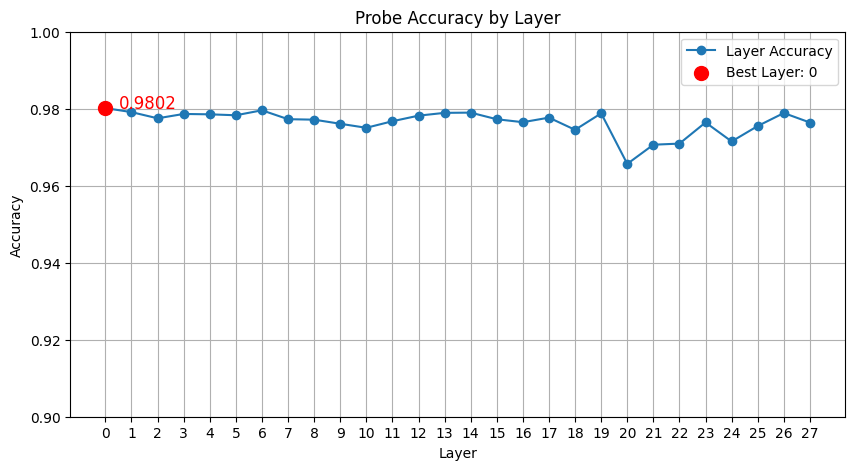

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("layer_probe_results.csv")

# Find best layer
best_row = df.loc[df['accuracy'].idxmax()]
best_layer = int(best_row['layer'])
best_acc = best_row['accuracy']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["layer"], df["accuracy"], marker="o", label="Layer Accuracy")
plt.scatter(best_layer, best_acc, color='red', s=100, zorder=5, label=f"Best Layer: {best_layer}")
plt.text(best_layer + 0.5, best_acc, f"{best_acc:.4f}", color='red', fontsize=12)

plt.title("Probe Accuracy by Layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(range(df["layer"].min(), df["layer"].max()+1))
plt.ylim(0.9, 1.0)
plt.legend()
plt.savefig("layer_probe_accuracy.png")
plt.show()


In [ ]:
from google.colab import files
files.download('layer_probe_accuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Mounting google drive in Colab


In [ ]:
# Creating folders
from google.colab import drive
import os

# mount Google Drive
drive.mount('/content/drive')

# Define the base folder path
base_dir = '/content/drive/MyDrive/LLM-Probing'

# Create folders

folders = [
    'Toy',
    'PTS',
    'PTS/logs'
]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save the toy examples result to google docs





In [ ]:
import json
torch.save(model.state_dict(), '/content/drive/MyDrive/toy_probe_weights.pt')

with open('/content/drive/MyDrive/toy_probe_metrics.json', 'w') as f:
    json.dump({"val_accuracy": 0.82, "layer": 15}, f)


## Generate aligned token-level ```is_pivotal``` labels from the PTS dataset


Based on the data in the [PTS repo](https://github.com/codelion/pts)

We want to:
1. Tokenize the text(using Qwen tokenizer)
2. Align the pivotal words to tokens
3. Mark each token with a binary label
- `1` if it maps to a pivotal word
- `0` otherwise

In [ ]:
def get_token_labels(text, tokenizer, pivotal_words):
  # Tokenize text with character offsets

  encoded = tokenizer(text, return_offsets_mapping=True, return_tensors="pt")
  offsets = encoded.offset_mapping[0].tolist()
  tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[0])

  # Find character spans of each pivotal word
  token_labels = []
  for start, end in offsets:
    token_str = text[start:end]
    is_pivotal = any(token_str in word for word in pivotal_words)
    token_labels.append(1 if is_pivotal else 0)

  return encoded, token_labels

In [ ]:
'''
# Tokenize and run input
text = "The quick brown fox jumps over the lazy dog"
pivotal_words = ["quick", "jumps", "dog"]
inputs = tokenizer(text, return_tensors="pt")
# we don't want the model to update the parameters so we don't use gradient descent
with torch.no_grad():
    _ = model(**inputs)

'''


```pivotal_tokens``` should be a list of strings be a list of strings, like ```["quick", "jumps", "dogs"]```

In [ ]:
encoded, token_labels = get_token_labels(samples[0].text, tokenizer, samples[0].pivotal_words)

AttributeError: 'dict' object has no attribute 'text'

The Qwen2 uses a hidden size of 1024, that's the hidden_dim


In [ ]:
# Align activations with pivotal labels
resid = resid.squeeze(0) # [seq_len, 1024]
labels = torch.tensor(token_labels).float() # [seq_len]

In [ ]:
# Custom Collate Function
def flatten_collate(batch):
  x_list, y_list = zip(*batch)
  x = torch.cat(x_list, dim=0)
  y = torch.cat(y_list, dim=0)
  return x, y


## Evaluate Accuracy


In [ ]:
with torch.no_grad():
  correct, total = 0, 0
  for x, y in dataloader:
    preds = probe(x)
    preds = (preds >= 0.5).float()
    correct += (preds == y).sum().item()
    total += y.size(0)

  acc = correct/total
  print(f"Accuracy: {acc: .4f}")

NameError: name 'dataloader' is not defined